# Combine exposure tiles to construct with-elevation, without-elevation, and area-by-elevation exposure parquets
Take all the 1-degree by 1-degree binned exposure tiles and combine them to form three global datasets:
1. "With-elevation" binned exposure: Includes all areas with elevations up to `sset.HIGHEST_WITHELEV_EXPOSURE_METERS`
2. "Without-elevation" binned exposure: Includes all global exposure
3. Area-by-seg-adm1: For each segment and adm1 region, the total area, in square kilometers, that is closer to that segment than to any other segment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shlex
import subprocess

import geopandas as gpd
import numpy as np
import pandas as pd
import sliiders.settings as sset
from dask_gateway import GatewayCluster
from sliiders.dask import start_cluster
from sliiders.io import read_parquet_dask, save, save_geoparquet

In [3]:
N_WORKERS = 35

In [6]:
client, cluster = start_cluster()
cluster.scale(N_WORKERS)
cluster

In [8]:
client.wait_for_workers(N_WORKERS)

exp_df = read_parquet_dask(sset.DIR_EXPOSURE_BINNED_TMP_TILES / "*.parquet").compute()

area_by_elev = read_parquet_dask(
    sset.DIR_EXPOSURE_BINNED_TMP_TILES_SEGMENT_AREA / "*.parquet"
).compute()

cluster.close(), client.close()

(None, None)

In [9]:
exp_df = exp_df.groupby(["seg_adm", "protection_zone", "z_ix"], observed=True).sum()
area_by_elev = area_by_elev.groupby(
    ["seg_adm", "z_ix", "wetland_flag", "protection_zone"], observed=True
).sum()
area_by_elev = (
    area_by_elev.area_km.unstack("wetland_flag")
    .rename(columns={False: "land_area_km", True: "wetland_area_km"})
    .rename_axis(columns=None)
    .fillna(0)
)

In [12]:
column_dtypes = {
    "z_ix": "int16",
    "seg_reg": "category",
    "protection_zone": "int16",
    "land_area_km": "float32",
    "wetland_area_km": "float32",
    "asset_value": "float32",
    "area_km": "float32",
    "pop": "float32",
}

highest_z_ix = (
    int(sset.HIGHEST_WITHELEV_EXPOSURE_METERS / sset.EXPOSURE_BIN_WIDTH_V) - 1
)
area_by_elev = area_by_elev[
    area_by_elev.index.get_level_values("z_ix") <= highest_z_ix
].reset_index()

withoutelev_df = exp_df.groupby("seg_adm", observed=True).sum().reset_index()

withelev_df = exp_df.loc[pd.IndexSlice[:, :, :highest_z_ix]].reset_index()


def drop_no_exp(df):
    return df[df["asset_value"].gt(0) | df["pop"].gt(0)].copy()


def parse_adm1(df):
    df["adm1"] = df.seg_adm.str[15:].values
    df["ISO"] = df.adm1.str[:3].values

    return df

In [14]:
area_by_elev = parse_adm1(area_by_elev)
withelev_df = parse_adm1(drop_no_exp(withelev_df))
withoutelev_df = parse_adm1(drop_no_exp(withoutelev_df))

## Rescale asset value to country-level estimates

In [15]:
# load country table
ktable_full = (
    pd.read_parquet(
        sset.PATH_EXPOSURE_YPK_COUNTRY_HIST_INT,
        filters=[("year", "=", sset.SOCIOECONOMIC_SCALE_YR)],
        columns=["rnna_19", "pop"],
    )
    .droplevel("year")
    .rename(columns={"rnna_19": "asset_value"})
)

assert np.isin(
    area_by_elev.ISO.unique(), ktable_full.index.tolist() + sset.UNINHABITED_ISOS
).all()
assert np.isin(
    ktable_full.index.tolist(),
    np.concatenate((withoutelev_df.ISO.unique(), sset.UNINHABITED_ISOS)),
).all()

# get current country-level totals
country_totals = withoutelev_df.groupby("ISO")[["asset_value", "pop"]].sum()

# adjust dataframes
adjustment = (ktable_full / country_totals).rename(columns=lambda x: x + "_adj")


def correct_vals(df):
    out = df.copy()
    out = out.join(adjustment, on="ISO")
    for varname in ["asset_value", "pop"]:
        out[varname] *= out[varname + "_adj"]
        out = out.drop(columns=varname + "_adj")
    return out

In [16]:
withoutelev_df = correct_vals(withoutelev_df)
withelev_df = correct_vals(withelev_df)

## Diagnostics

In [17]:
withelev_df["asset_value"].sum() / 1e12

139.36470581285354

In [18]:
withoutelev_df["asset_value"].sum() / 1e12

567.3817309949764

In [19]:
withelev_df["pop"].sum() / 1e9

1.2480259502359143

In [20]:
withoutelev_df["pop"].sum() / 1e9

7.71172042

In [21]:
ktable_full.sum()

asset_value    5.673817e+14
pop            7.711723e+09
dtype: float64

<Axes: xlabel='z_ix'>

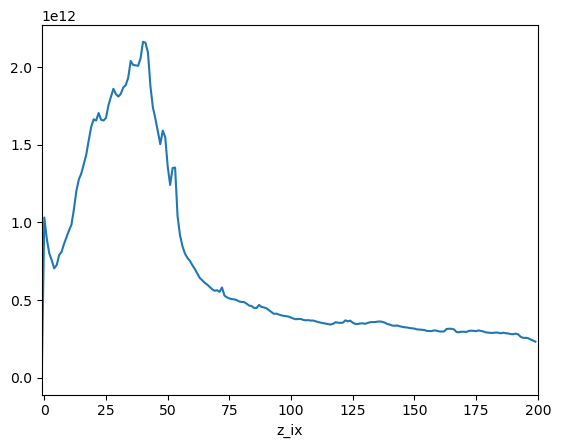

In [22]:
withelev_df.groupby("z_ix").asset_value.sum().plot(xlim=(-1, 200))

<Axes: xlabel='z_ix'>

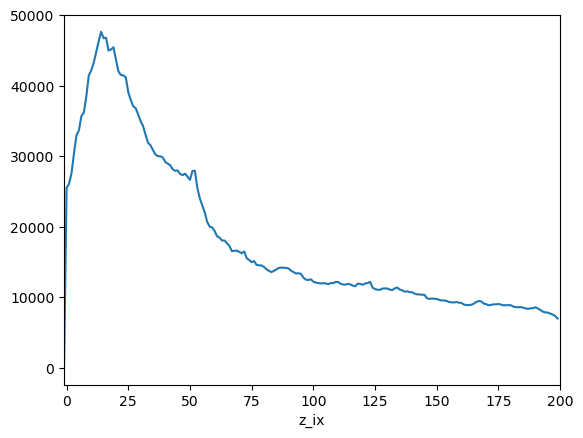

In [26]:
withelev_df.groupby("z_ix").area_km.sum().plot(xlim=(-1, 200))

In [27]:
withelev_df.groupby("z_ix").asset_value.sum()

z_ix
-662    2.962816e+05
-592    5.925631e+05
-552    1.137455e+02
-532    2.962823e+05
-512    1.137462e+02
            ...     
 195    2.569616e+11
 196    2.551313e+11
 197    2.468789e+11
 198    2.396297e+11
 199    2.325614e+11
Name: asset_value, Length: 541, dtype: float64

## Save

In [28]:
def fix_type(df):
    dtype_dict = {
        "z_ix": "int16",
        "adm1": "category",
        "ISO": "category",
    }
    return df.astype({k: v for k, v in dtype_dict.items() if k in df.columns})


withoutelev_df = fix_type(withoutelev_df)
withelev_df = fix_type(withelev_df)
area_by_elev = fix_type(area_by_elev)

In [31]:
save(withelev_df, sset.PATH_EXPOSURE_BINNED_WITHELEV, index=False)
save(withoutelev_df, sset.PATH_EXPOSURE_BINNED_WITHOUTELEV, index=False)
save(area_by_elev, sset.PATH_EXPOSURE_AREA_BY_CIAM_AND_ELEVATION, index=False)

## Add `lowelev` field to CIAM-Adm1 intersections file to indicate inclusion in elevation processing

In [32]:
ciam_adm1 = gpd.read_parquet(sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS)
ciam_adm1["lowelev"] = ciam_adm1.index.isin(area_by_elev["seg_adm"].unique())

In [33]:
save_geoparquet(
    ciam_adm1, sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS, row_group_size=500
)

### Check that it looks good

#### withelev

In [34]:
withelev_out = pd.read_parquet(sset.PATH_EXPOSURE_BINNED_WITHELEV)

In [35]:
withelev_out.head()

,seg_adm,protection_zone,z_ix,asset_value,pop,area_km,adm1,ISO
0,seg_09752_adm1_STP.2_1,-1,0,22574.867966,38.758840,0.370492,STP.2_1,STP
1,seg_09752_adm1_STP.2_1,-1,1,16551.062569,63.860048,0.470496,STP.2_1,STP
2,seg_09752_adm1_STP.2_1,-1,2,25430.227031,68.828718,0.611455,STP.2_1,STP
3,seg_09752_adm1_STP.2_1,-1,3,34930.215018,114.053059,0.636218,STP.2_1,STP
4,seg_09752_adm1_STP.2_1,-1,4,17302.811864,69.076578,0.382874,STP.2_1,STP


In [36]:
withelev_out["asset_value"].sum() / 1e12

139.36470581285354

#### withoutelev

In [37]:
withoutelev_out = pd.read_parquet(sset.PATH_EXPOSURE_BINNED_WITHOUTELEV)

In [38]:
withoutelev_out.head()

,seg_adm,asset_value,pop,area_km,adm1,ISO
0,seg_09752_adm1_STP.2_1,3.009728e+06,1590.258425,197.812677,STP.2_1,STP
1,seg_09753_adm1_STP.2_1,3.726945e+09,183461.276859,385.310210,STP.2_1,STP
2,seg_09754_adm1_STP.2_1,2.156393e+07,21033.399972,272.406773,STP.2_1,STP
3,seg_13347_adm1_STP.1_1,6.240720e+05,114.027888,62.765681,STP.1_1,STP
4,seg_17602_adm1_GAB.1_1,1.435397e+08,1844.144709,4398.484089,GAB.1_1,GAB


In [39]:
withoutelev_out["asset_value"].sum() / 1e12

567.3817309949764

#### CIAM area-by-elevation

In [40]:
area = pd.read_parquet(sset.PATH_EXPOSURE_AREA_BY_CIAM_AND_ELEVATION)

<Axes: xlabel='z_ix'>

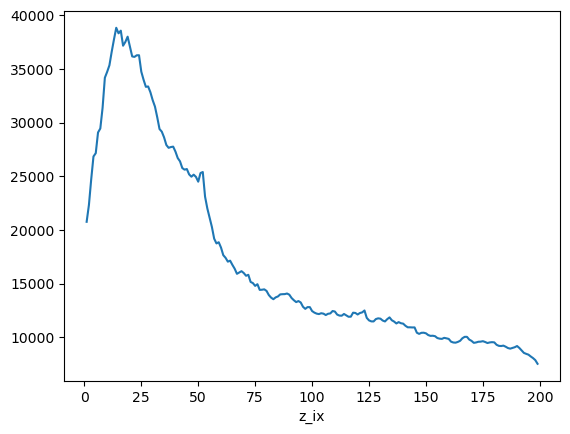

In [41]:
area.groupby("z_ix").land_area_km.sum().loc[1:].plot()

The "areas" file includes some wetland area that wouldn't necessarily exist in the "withelev" file, so we confirm that there are no locations where the "withelev" file has greater area than the "areas" file.

In [42]:
area_areas = (
    area[["seg_adm", "protection_zone", "z_ix", "land_area_km", "wetland_area_km"]]
    .set_index(["seg_adm", "protection_zone", "z_ix"])
    .sum(axis=1)
)
we_areas = withelev_df.set_index(["seg_adm", "protection_zone", "z_ix"]).area_km
assert ((area_areas.loc[we_areas.index] - we_areas) > -1e-12).all()

## Clean temp files

In [50]:
sset.DIR_EXPOSURE_BINNED_TMP.rmtree()